# Linear Regression Models

This notebook fits multiple OLS regression models to explain `Price_USD`.

- Trip attributes (Duration, Stops)
- Airline fixed effects
- Time-of-day cyclical features (departure/arrival)
- Calendar features (day-of-week, month)
- Origin/Destination fixed effects
- Interaction terms

## 0. Import Libraries

In [17]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import HTML, display

## 1. Load processed dataset

In [18]:
DATA_PATH = "../data/processed/flight_prices_processed.csv"
df = pd.read_csv(DATA_PATH)

df.shape, df.head()

((10660, 13),
        Airline    Source Destination  Total_Stops  Price  Price_USD  \
 0       IndiGo  Banglore   New Delhi            0   3897     46.764   
 1    Air India   Kolkata    Banglore            2   7662     91.944   
 2  Jet Airways     Delhi      Cochin            2  13882    166.584   
 3       IndiGo   Kolkata    Banglore            1   6218     74.616   
 4       IndiGo  Banglore   New Delhi            1  13302    159.624   
 
    Duration_min  Journey_day  Journey_month  Dep_hour  Dep_min  Arr_hour  \
 0           170           24              3        22       20         1   
 1           445            1              5         5       50        13   
 2          1140            9              6         9       25         4   
 3           325           12              5        18        5        23   
 4           285            1              3        16       50        21   
 
    Arr_min  
 0       10  
 1       15  
 2       25  
 3       30  
 4       35  )

## 2. Sanity Checks

In [19]:
df.dtypes

Airline           object
Source            object
Destination       object
Total_Stops        int64
Price              int64
Price_USD        float64
Duration_min       int64
Journey_day        int64
Journey_month      int64
Dep_hour           int64
Dep_min            int64
Arr_hour           int64
Arr_min            int64
dtype: object

In [20]:
df.isna().sum().sort_values(ascending=False).head(15)

Airline          0
Source           0
Destination      0
Total_Stops      0
Price            0
Price_USD        0
Duration_min     0
Journey_day      0
Journey_month    0
Dep_hour         0
Dep_min          0
Arr_hour         0
Arr_min          0
dtype: int64

In [21]:
df[["Price_USD", "Duration_min", "Total_Stops"]].describe()

,Price_USD,Duration_min,Total_Stops
count,10660.000000,10660.000000,10660.000000
mean,108.683845,643.462008,0.823827
std,53.484676,508.248688,0.675600
min,21.108000,5.000000,0.000000
25%,63.204000,170.000000,0.000000
50%,100.464000,520.000000,1.000000
75%,148.476000,930.000000,1.000000
max,657.912000,2860.000000,4.000000


## 3. Specific Feature Enngineering

In [26]:
df_linear = df.copy()

### 3-1. Date Construction

In [27]:
df_linear["Date"] = pd.to_datetime(
    df_linear["Journey_day"].astype(str) + "-" +
    df_linear["Journey_month"].astype(str) + "-2019",
    errors="coerce"
)

df_linear[["Journey_day", "Journey_month", "Date"]].head()

/var/folders/1l/r_1yydhs67v0kv8qhmgmnh5w0000gp/T/ipykernel_29642/1411039274.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_linear["Date"] = pd.to_datetime(


,Journey_day,Journey_month,Date
0,24,3,2019-03-24
1,1,5,2019-05-01
2,9,6,2019-06-09
3,12,5,2019-05-12
4,1,3,2019-03-01


### 3-2. Outlier Trimming for OLS

In [28]:
df_linear = df_linear[df_linear["Price_USD"] < 600].copy()
df_linear.shape

(10657, 14)

### 3-3. Cyclical Encoding

In [29]:
df_linear["dep_hour_sin"] = np.sin(2 * np.pi * df_linear["Dep_hour"] / 24)
df_linear["dep_hour_cos"] = np.cos(2 * np.pi * df_linear["Dep_hour"] / 24)

df_linear["arr_hour_sin"] = np.sin(2 * np.pi * df_linear["Arr_hour"] / 24)
df_linear["arr_hour_cos"] = np.cos(2 * np.pi * df_linear["Arr_hour"] / 24)

In [30]:
df_linear["dow"] = df_linear["Date"].dt.dayofweek
df_linear["month"] = df_linear["Date"].dt.month

df_linear["dow_sin"]   = np.sin(2 * np.pi * df_linear["dow"] / 7)
df_linear["dow_cos"]   = np.cos(2 * np.pi * df_linear["dow"] / 7)

df_linear["month_sin"] = np.sin(2 * np.pi * df_linear["month"] / 12)
df_linear["month_cos"] = np.cos(2 * np.pi * df_linear["month"] / 12)

## 4. Linear Regression Models

### Model 1 — Baseline Model (Duration, Stops, Airline)

In [31]:
fit_1 = smf.ols(
    "Price_USD ~ Duration_min + Total_Stops + C(Airline)",
    data=df_linear
).fit()

fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     1412.
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:02:48   Log-Likelihood:                -53185.
No. Observations:               10657   AIC:                         1.064e+05
Df Residuals:                   10647   BIC:                         1.065e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          49.5517      2.016     24.576      0.000      45.600      53.504
C(Airline)[T.Air India]            18.6958      2.228      8.391      0.000      14.328      23.063
C(Airline)[T.GoAir]                 1.1405      3.242      0.352      0.725      -5.215       7.495
C(Airline)[T.IndiGo]                3.2086      2.143      1.497      0.134      -0.991       7.409
C(Airline)[T.Jet Airways]          50.7562      2.115     23.998      0.000      46.610      54.902
C(Airline)[T.Multiple carriers]    41.9751      2.270     18.488      0.000      37.525      46.426
C(Airline)[T.SpiceJet]             -4.5293      2.356     -1.923      0.055      -9.147       0.088
C(Airline)[T.Vistara]              25.9742      2.587     10.041      0.000      20.904      31.045
Duration_min                        0.0037      0.001      3.432      0.001       0.002       0.006
Total_Stops                        35.2623      0.794     44.393      0.000      33.705      36.819
==============================================================================
Omnibus:                     4788.194   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45565.159
Skew:                           1.916   Prob(JB):                         0.00
Kurtosis:                      12.377   Cond. No.                     1.38e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 2 — Adding Time-of-Day Effects

In [33]:
fit_2 = smf.ols(
    """
    Price_USD ~ Duration_min + Total_Stops + C(Airline)
    + dep_hour_sin + dep_hour_cos
    + arr_hour_sin + arr_hour_cos
    """,
    data=df_linear
).fit()

fit_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     979.1
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:03:56   Log-Likelihood:                -53179.
No. Observations:               10657   AIC:                         1.064e+05
Df Residuals:                   10643   BIC:                         1.065e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          49.5913      2.017     24.587      0.000      45.638      53.545
C(Airline)[T.Air India]            18.1590      2.241      8.105      0.000      13.767      22.551
C(Airline)[T.GoAir]                 0.9070      3.254      0.279      0.780      -5.471       7.285
C(Airline)[T.IndiGo]                2.9453      2.146      1.372      0.170      -1.262       7.152
C(Airline)[T.Jet Airways]          50.2850      2.124     23.674      0.000      46.121      54.448
C(Airline)[T.Multiple carriers]    41.2699      2.322     17.774      0.000      36.718      45.821
C(Airline)[T.SpiceJet]             -4.6268      2.362     -1.959      0.050      -9.257       0.003
C(Airline)[T.Vistara]              25.5089      2.595      9.830      0.000      20.422      30.596
Duration_min                        0.0037      0.001      3.471      0.001       0.002       0.006
Total_Stops                        35.3203      0.804     43.913      0.000      33.744      36.897
dep_hour_sin                       -1.1405      0.494     -2.309      0.021      -2.109      -0.172
dep_hour_cos                       -1.2118      0.647     -1.873      0.061      -2.480       0.057
arr_hour_sin                       -0.5147      0.538     -0.956      0.339      -1.570       0.540
arr_hour_cos                        0.1887      0.571      0.330      0.741      -0.931       1.309
==============================================================================
Omnibus:                     4798.830   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45820.488
Skew:                           1.920   Prob(JB):                         0.00
Kurtosis:                      12.405   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 3 — Adding Calendar Effects

In [34]:
fit_3 = smf.ols(
    """
    Price_USD ~ Duration_min + Total_Stops + C(Airline)
    + dep_hour_sin + dep_hour_cos
    + arr_hour_sin + arr_hour_cos
    + dow_sin + dow_cos
    + month_sin + month_cos
    """,
    data=df_linear
).fit()

fit_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     857.3
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:04:26   Log-Likelihood:                -52773.
No. Observations:               10657   AIC:                         1.056e+05
Df Residuals:                   10639   BIC:                         1.057e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          73.9553      2.963     24.963      0.000      68.148      79.763
C(Airline)[T.Air India]            16.4721      2.158      7.633      0.000      12.242      20.702
C(Airline)[T.GoAir]                -0.0439      3.133     -0.014      0.989      -6.185       6.097
C(Airline)[T.IndiGo]                1.2725      2.068      0.615      0.538      -2.780       5.325
C(Airline)[T.Jet Airways]          50.3565      2.045     24.619      0.000      46.347      54.366
C(Airline)[T.Multiple carriers]    41.3614      2.239     18.475      0.000      36.973      45.750
C(Airline)[T.SpiceJet]             -5.1772      2.274     -2.276      0.023      -9.635      -0.719
C(Airline)[T.Vistara]              24.9924      2.499     10.002      0.000      20.094      29.891
Duration_min                        0.0028      0.001      2.663      0.008       0.001       0.005
Total_Stops                        36.3417      0.778     46.683      0.000      34.816      37.868
dep_hour_sin                       -1.9658      0.476     -4.126      0.000      -2.900      -1.032
dep_hour_cos                       -1.8699      0.624     -2.998      0.003      -3.092      -0.647
arr_hour_sin                       -0.2947      0.518     -0.568      0.570      -1.311       0.721
arr_hour_cos                        0.1722      0.550      0.313      0.754      -0.906       1.251
dow_sin                            -5.0097      0.472    -10.624      0.000      -5.934      -4.085
dow_cos                            -1.8093      0.485     -3.728      0.000      -2.761      -0.858
month_sin                          -9.1025      1.942     -4.687      0.000     -12.910      -5.295
month_cos                          29.5269      1.896     15.574      0.000      25.810      33.243
==============================================================================
Omnibus:                     3633.544   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29656.309
Skew:                           1.408   Prob(JB):                         0.00
Kurtosis:                      10.672   Cond. No.                     1.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 4 — Full Model with Origin/Destination Fixed Effects

In [35]:
fit_4 = smf.ols(
    """
    Price_USD ~ Duration_min + Total_Stops + C(Airline)
    + dep_hour_sin + dep_hour_cos
    + arr_hour_sin + arr_hour_cos
    + dow_sin + dow_cos
    + month_sin + month_cos
    + C(Source) + C(Destination)
    """,
    data=df_linear
).fit()

fit_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     712.4
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:04:50   Log-Likelihood:                -52544.
No. Observations:               10657   AIC:                         1.051e+05
Df Residuals:                   10634   BIC:                         1.053e+05
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          56.3211      2.434     23.138      0.000      51.550      61.092
C(Airline)[T.Air India]            19.8510      2.145      9.252      0.000      15.645      24.057
C(Airline)[T.GoAir]                 1.1774      3.081      0.382      0.702      -4.862       7.217
C(Airline)[T.IndiGo]                3.1572      2.041      1.547      0.122      -0.843       7.158
C(Airline)[T.Jet Airways]          52.4020      2.023     25.909      0.000      48.437      56.366
C(Airline)[T.Multiple carriers]    44.1334      2.243     19.672      0.000      39.736      48.531
C(Airline)[T.SpiceJet]             -3.3855      2.250     -1.505      0.132      -7.796       1.025
C(Airline)[T.Vistara]              26.2374      2.463     10.652      0.000      21.409      31.066
C(Source)[T.Chennai]                6.0433      0.881      6.860      0.000       4.316       7.770
C(Source)[T.Delhi]                  5.7155      0.492     11.621      0.000       4.751       6.680
C(Source)[T.Kolkata]               13.7246      0.962     14.274      0.000      11.840      15.609
C(Source)[T.Mumbai]                -3.4383      0.676     -5.085      0.000      -4.764      -2.113
C(Destination)[T.Cochin]            5.7155      0.492     11.621      0.000       4.751       6.680
C(Destination)[T.Delhi]             3.4246      1.141      3.001      0.003       1.187       5.662
C(Destination)[T.Hyderabad]        -3.4383      0.676     -5.085      0.000      -4.764      -2.113
C(Destination)[T.Kolkata]           6.0433      0.881      6.860      0.000       4.316       7.770
C(Destination)[T.New Delhi]        30.8515      1.149     26.857      0.000      28.600      33.103
Duration_min                        0.0011      0.001      1.055      0.292      -0.001       0.003
Total_Stops                        33.3950      0.872     38.297      0.000      31.686      35.104
dep_hour_sin                       -1.5934      0.470     -3.392      0.001      -2.514      -0.673
dep_hour_cos                       -1.2008      0.613     -1.959      0.050      -2.402       0.001
arr_hour_sin                       -0.1410      0.508     -0.277      0.782      -1.138       0.856
arr_hour_cos                        0.5225      0.540      0.967      0.334      -0.537       1.582
dow_sin                            -4.0595      0.464     -8.751      0.000      -4.969      -3.150
dow_cos                            -1.6373      0.475     -3.445      0.001      -2.569      -0.706
month_sin                          -6.3378      2.000     -3.170      0.002     -10.257      -2.418
month_cos                          20.2371      2.090      9.684      0.000      16.141      24.333
==============================================================================
Omni

## 5. Interaction Models

### Model 5 — Duration × Stops Interaction

In [36]:
fit_5 = smf.ols(
    """
    Price_USD ~ Duration_min * Total_Stops
    + C(Airline)
    + dep_hour_sin + dep_hour_cos
    + arr_hour_sin + arr_hour_cos
    + dow_sin + dow_cos
    + month_sin + month_cos
    + C(Source) + C(Destination)
    """,
    data=df_linear
).fit()

fit_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     692.9
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:06:11   Log-Likelihood:                -52491.
No. Observations:               10657   AIC:                         1.050e+05
Df Residuals:                   10633   BIC:                         1.052e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          53.5023      2.437     21.952      0.000      48.725      58.280
C(Airline)[T.Air India]            20.5177      2.136      9.607      0.000      16.331      24.704
C(Airline)[T.GoAir]                -0.0351      3.068     -0.011      0.991      -6.049       5.979
C(Airline)[T.IndiGo]                2.9685      2.031      1.462      0.144      -1.012       6.949
C(Airline)[T.Jet Airways]          50.1166      2.025     24.755      0.000      46.148      54.085
C(Airline)[T.Multiple carriers]    41.0555      2.252     18.231      0.000      36.641      45.470
C(Airline)[T.SpiceJet]             -2.3517      2.241     -1.049      0.294      -6.744       2.041
C(Airline)[T.Vistara]              24.6020      2.456     10.017      0.000      19.788      29.416
C(Source)[T.Chennai]                6.8537      0.880      7.788      0.000       5.129       8.579
C(Source)[T.Delhi]                  4.3217      0.508      8.515      0.000       3.327       5.317
C(Source)[T.Kolkata]               10.8281      0.997     10.863      0.000       8.874      12.782
C(Source)[T.Mumbai]                -2.3038      0.682     -3.380      0.001      -3.640      -0.968
C(Destination)[T.Cochin]            4.3217      0.508      8.515      0.000       3.327       5.317
C(Destination)[T.Delhi]             5.6033      1.155      4.852      0.000       3.339       7.867
C(Destination)[T.Hyderabad]        -2.3038      0.682     -3.380      0.001      -3.640      -0.968
C(Destination)[T.Kolkata]           6.8537      0.880      7.788      0.000       5.129       8.579
C(Destination)[T.New Delhi]        28.1993      1.171     24.074      0.000      25.903      30.495
Duration_min                        0.0157      0.002      9.013      0.000       0.012       0.019
Total_Stops                        41.4868      1.167     35.536      0.000      39.198      43.775
Duration_min:Total_Stops           -0.0120      0.001    -10.360      0.000      -0.014      -0.010
dep_hour_sin                       -1.4503      0.468     -3.102      0.002      -2.367      -0.534
dep_hour_cos                       -0.9643      0.610     -1.580      0.114      -2.161       0.232
arr_hour_sin                       -0.2217      0.506     -0.438      0.661      -1.213       0.770
arr_hour_cos                        0.3590      0.538      0.667      0.504      -0.695       1.413
dow_sin                            -4.2983      0.462     -9.301      0.000      -5.204      -3.392
dow_cos                            -1.7292      0.473     -3.656      0.000      -2.656      -0.802
month_sin                          -7.0728      1.991     -3.552      0.000     -10.975      -3.170
month_cos                          21.1863      2.081     10.179      0.000      17

### Model 6 — Stops × Airline Interaction

In [37]:
fit_6 = smf.ols(
    """
    Price_USD ~ Total_Stops * C(Airline)
    + Duration_min
    + dep_hour_sin + dep_hour_cos
    + arr_hour_sin + arr_hour_cos
    + dow_sin + dow_cos
    + month_sin + month_cos
    + C(Source) + C(Destination)
    """,
    data=df_linear
).fit()

fit_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_USD   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.598
Method:                 Least Squares   F-statistic:                     547.9
Date:                Sun, 21 Dec 2025   Prob (F-statistic):               0.00
Time:                        21:06:42   Log-Likelihood:                -52498.
No. Observations:               10657   AIC:                         1.051e+05
Df Residuals:                   10627   BIC:                         1.053e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                      58.6730      2.728     21.507      0.000      53.325      64.020
C(Airline)[T.Air India]                        14.9531      2.870      5.210      0.000       9.328      20.579
C(Airline)[T.GoAir]                             2.6836      4.296      0.625      0.532      -5.738      11.105
C(Airline)[T.IndiGo]                            3.9543      2.646      1.494      0.135      -1.232       9.141
C(Airline)[T.Jet Airways]                      45.7198      2.717     16.827      0.000      40.394      51.046
C(Airline)[T.Multiple carriers]                29.6239      5.050      5.866      0.000      19.725      39.523
C(Airline)[T.SpiceJet]                         -5.9701      2.801     -2.131      0.033     -11.461      -0.479
C(Airline)[T.Vistara]                          20.0645      3.239      6.195      0.000      13.716      26.413
C(Source)[T.Chennai]                            5.2024      0.908      5.732      0.000       3.423       6.981
C(Source)[T.Delhi]                              7.0982      0.542     13.108      0.000       6.037       8.160
C(Source)[T.Kolkata]                           14.5896      1.003     14.549      0.000      12.624      16.555
C(Source)[T.Mumbai]                            -3.3877      0.701     -4.830      0.000      -4.762      -2.013
C(Destination)[T.Cochin]                        7.0982      0.542     13.108      0.000       6.037       8.160
C(Destination)[T.Delhi]                         3.3546      1.183      2.836      0.005       1.036       5.673
C(Destination)[T.Hyderabad]                    -3.3877      0.701     -4.830      0.000      -4.762      -2.013
C(Destination)[T.Kolkata]                       5.2024      0.908      5.732      0.000       3.423       6.981
C(Destination)[T.New Delhi]                    31.8159      1.180     26.965      0.000      29.503      34.129
Total_Stops                                    25.0194      3.459      7.234      0.000      18.240      31.799
Total_Stops:C(Airline)[T.Air India]             9.5012      3.552      2.675      0.007       2.539      16.463
Total_Stops:C(Airline)[T.GoAir]                -2.6788      5.917     -0.453      0.651     -14.276       8.919
Total_Stops:C(Airline)[T.IndiGo]               -3.4660      3.716     -0.933      0.351     -10.751       3.819
Total_Stops:C(Airline)[T.Jet Airways]          11.5000      3.530      3.257      0.001       4.580      18.420
Total_Stops:C(Airline)[T.Multiple carriers]    16.8414      5.249      3.209      0.001       6.552      27.130
Total_Stops:C(Airline)[T.SpiceJet]              3.2231      4.583      0.703      0.482      -5.761      12.207
Total_Stops:C(Airline)[T.Vistara]              15.4393     

## 6. Model Diagnostics

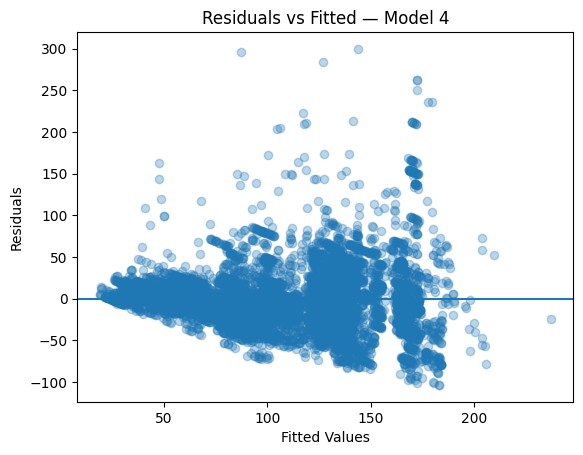

In [38]:
import matplotlib.pyplot as plt

resid = fit_4.resid
fitted = fit_4.fittedvalues

plt.scatter(fitted, resid, alpha=0.3)
plt.axhline(0)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted — Model 4")
plt.show()

## 7. Summary

- Flight duration and number of stops are the strongest predictors.
- Time-of-day and calendar effects provide incremental explanatory power.
- Origin and destination fixed effects improve model fit.
- Interaction terms show heterogeneous pricing effects across different segments.
